/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 150)             │          97,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 150)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 50, 100)             │          75,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 204,301 (798.05 KB)

 Trainable params: 204,301 (798.05 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 280ms/step - loss: 0.0126 - val_loss: 0.0245
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - loss: 0.0050 - val_loss: 0.0083
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - loss: 0.0025 - val_loss: 0.0100
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - loss: 0.0025 - val_loss: 0.0078
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - loss: 0.0018 - val_loss: 0.0096
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 363ms/step - loss: 0.0017 - val_loss: 0.0072
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - loss: 0.0014 - val_loss: 0.0079
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - loss: 0.0016 - val_loss: 0.0087
Epoch 9/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - loss: 0.0017 - val_loss: 0.0073
Epoch 10/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - loss: 0.0019 - val_loss: 0.0124
Epoch 11/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - loss: 0.0017 - val_loss: 0.0430
Epoch 12/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step

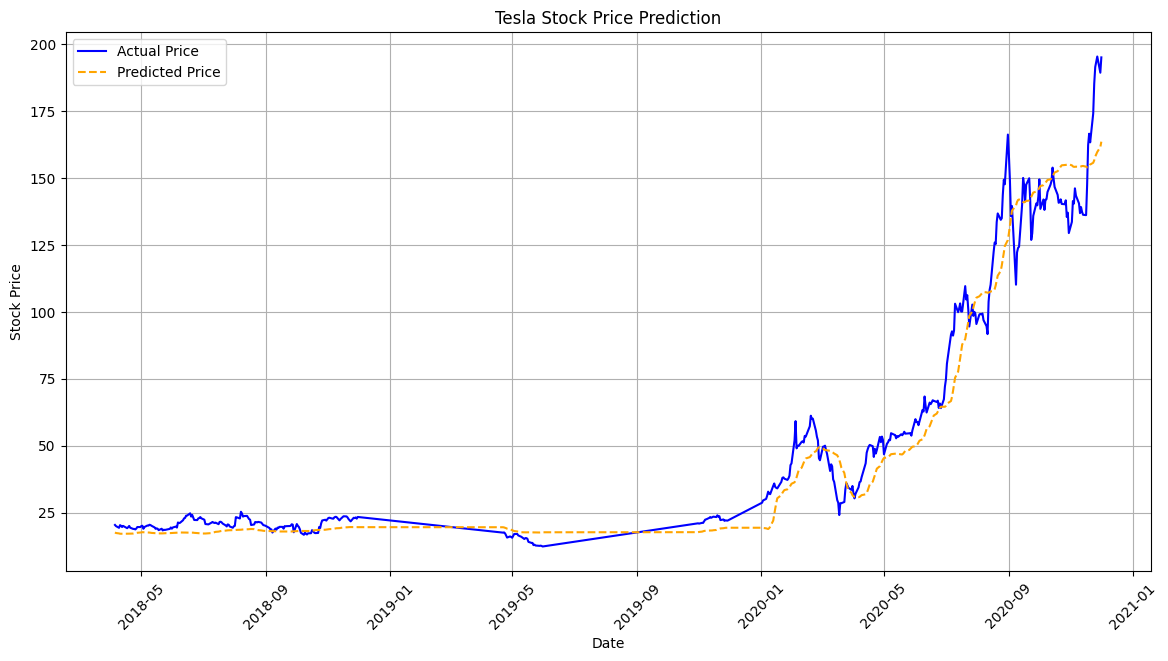

Mean Squared Error (MSE): 87.55627914171227
Mean Absolute Error (MAE): 6.712182489432339


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping

df = pd.read_csv('/Final_Tesla_stock_sentiment_2018_2020.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Feature engineering
df['dow'] = df.index.dayofweek
df['woy'] = df.index.isocalendar().week
df['lag_1'] = df['Close'].shift(1)
df['lag_7'] = df['Close'].shift(7)
df['lag_14'] = df['Close'].shift(14)
df['roll_mean_7'] = df['Close'].rolling(window=7).mean()
df['roll_std_7'] = df['Close'].rolling(window=7).std()
df['ema_7'] = df['Close'].ewm(span=7, adjust=False).mean()

features = ['avg_textblob_polarity', 'avg_vader_sentiment', 'dow', 'woy', 'lag_1', 'lag_7', 'lag_14', 'roll_mean_7', 'roll_std_7', 'ema_7']
target = 'Close'

df.dropna(subset=[target] + features, inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df[[target] + features])
def create_seq(data, seq_len):
    x, y = [], []
    for i in range(len(data) - seq_len):
        x.append(data[i:i + seq_len, :])
        y.append(data[i + seq_len, 0])
    return np.array(x), np.array(y)

seq_len = 50
x, y = create_seq(scaled, seq_len)

train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

#  LSTM model
model = Sequential([
    LSTM(150, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
    Dropout(0.3),
    GRU(100, return_sequences=True),
    Dropout(0.3),
    LSTM(50, return_sequences=False),
    Dropout(0.3),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train
history = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_test, y_test), verbose=1, callbacks=[early_stop])

# Predict
y_pred = model.predict(x)

y_actual = scaler.inverse_transform(np.concatenate([y.reshape(-1, 1), x[:, -1, 1:]], axis=1))[:, 0]
y_predicted = scaler.inverse_transform(np.concatenate([y_pred, x[:, -1, 1:]], axis=1))[:, 0]

plt.figure(figsize=(14, 7))
plt.plot(df.index[seq_len:], y_actual, label="Actual Price", color='blue')
plt.plot(df.index[seq_len:], y_predicted, label="Predicted Price", color='orange', linestyle='--')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# Key statistics
mse = np.mean((y_actual - y_predicted) ** 2)
mae = np.mean(np.abs(y_actual - y_predicted))
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")


In [6]:
actual_direction = np.sign(y_actual[1:] - y_actual[:-1])
predicted_direction = np.sign(y_predicted[1:] - y_predicted[:-1])
directional_accuracy = np.mean(actual_direction == predicted_direction) * 100
print(f"Directional Accuracy: {directional_accuracy:.2f}%")


Directional Accuracy: 56.57%
